In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# DATA 


In [143]:
cwd = os.getcwd() + "/"
train = cwd + "unetdataset/train"
test = cwd + "unetdataset/test"
input_train_list = os.listdir(os.path.join(train,"input"))
train_input_img_paths = []
train_target_img_paths = []
for name in input_train_list:
    input_path = train + "/input/" + name
    output_path = train + "/output/" + name
    train_input_img_paths.append(input_path)
    train_target_img_paths.append(output_path)

print(len(train_input_img_paths))

77213


In [125]:
class PCB_gen(keras.utils.Sequence):

    def __init__(self, input_img_paths, target_img_paths):
        self.batch_size = BATCH_SIZE
        self.img_size = (160,160)
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = (np.expand_dims(img, 2)/255).round().astype(int)
        return x, y

# MODEL

In [145]:
import random
BATCH_SIZE = 32

val_samples = len(train_input_img_paths) // 5
random.Random(1337).shuffle(train_input_img_paths)
random.Random(1337).shuffle(train_target_img_paths)

val_input_img_paths = train_input_img_paths[-val_samples:]
val_target_img_paths = train_target_img_paths[-val_samples:]

train_input_img_paths = train_input_img_paths[:-val_samples]
train_target_img_paths = train_target_img_paths[:-val_samples]

val_gen = PCB_gen(
    val_input_img_paths, 
    val_target_img_paths
)

train_gen = PCB_gen(
    train_input_img_paths, 
    train_target_img_paths
)

## building blocks

In [126]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [127]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [128]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)

    return x

## za model itself 

In [163]:
def build_unet_model():
    inputs = layers.Input(shape=(160,160,3))
    f1, p1 = downsample_block(inputs, 32)
    f2, p2 = downsample_block(p1, 64)
    f3, p3 = downsample_block(p2, 64)
    f4, p4 = downsample_block(p3, 128)

    bottleneck = double_conv_block(p4, 256)
    
    u6 = upsample_block(bottleneck, f4, 128)
    u7 = upsample_block(u6, f3, 64)
    u8 = upsample_block(u7, f2, 64)
    u9 = upsample_block(u8, f1, 32)

    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net-pcb")

    return unet_model

In [168]:
keras.backend.clear_session()

In [169]:
# do not run these again!
pcb_unet_model = build_unet_model()
pcb_unet_model.summary()
#tf.keras.utils.plot_model(unet_model, show_shapes=True)

Model: "U-Net-pcb"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 32  9248        ['conv2d[0][0]']                 
                                )                                                         

 concatenate_3 (Concatenate)    (None, 160, 160, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 dropout_7 (Dropout)            (None, 160, 160, 64  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 160, 160, 32  18464       ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 160, 160, 32  9248        ['conv2d_16[0][0]']              
          

In [170]:
optimizer=tf.keras.optimizers.Adam()
pcb_unet_model.compile(optimizer=optimizer,
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

#### We have more than 77k dedicated for the training in our data set of which 20% for validation and a batch size of 32 therefor about 2000 steps per epoch which is a lot and roughly equats to 10 standard epochs so we will only use 10 as nb of epochs.

In [171]:
NUM_EPOCHS = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("pcb_segmentation.h5", save_best_only=True)
]

model_history = pcb_unet_model.fit(train_gen,epochs=NUM_EPOCHS,validation_data=val_gen,verbose=1,callbacks=callbacks)

Epoch 1/10
1930/1930 [==============================] - 1148s 594ms/step - loss: 0.5618 - accuracy: 0.7012 - val_loss: 0.4086 - val_accuracy: 0.6453
Epoch 2/10
1930/1930 [==============================] - 1151s 596ms/step - loss: 0.3790 - accuracy: 0.6843 - val_loss: 0.3395 - val_accuracy: 0.6755
Epoch 3/10
1930/1930 [==============================] - 1155s 598ms/step - loss: 0.3402 - accuracy: 0.6857 - val_loss: 0.3036 - val_accuracy: 0.6776
Epoch 4/10
1930/1930 [==============================] - 1147s 594ms/step - loss: 0.3031 - accuracy: 0.6869 - val_loss: 0.2966 - val_accuracy: 0.6484
Epoch 5/10
1930/1930 [==============================] - 1147s 594ms/step - loss: 0.2780 - accuracy: 0.6945 - val_loss: 0.2431 - val_accuracy: 0.6995
Epoch 6/10
1930/1930 [==============================] - 1143s 592ms/step - loss: 0.2551 - accuracy: 0.6951 - val_loss: 0.2466 - val_accuracy: 0.7203
Epoch 7/10
1930/1930 [==============================] - 1143s 592ms/step - loss: 0.2407 - accuracy: 0.6945

In [172]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

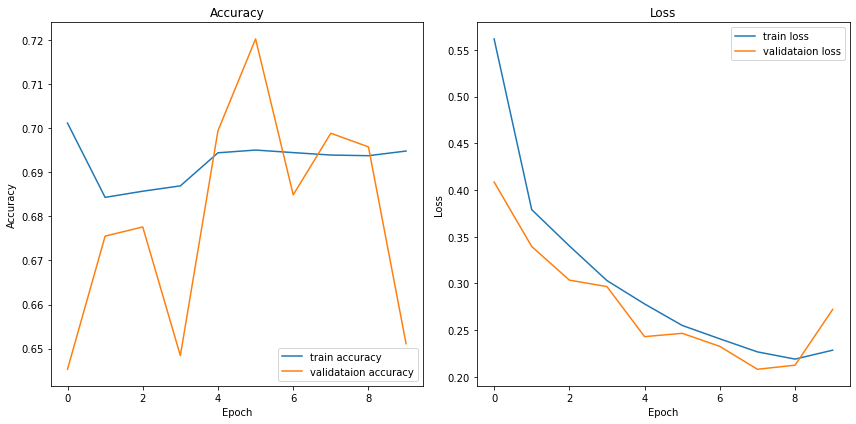

In [173]:
# Display learning curves 
display_learning_curves(pcb_unet_model.history)

In [181]:
pcb_unet_model.save(os.path.join(os.getcwd(),"pcb unet model"))

INFO:tensorflow:Assets written to: C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify\pcb unet model\assets


INFO:tensorflow:Assets written to: C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify\pcb unet model\assets


In [13]:
pcb_unet_model= keras.models.load_model(os.path.join(os.getcwd(),"pcb unet model"))

In [27]:
tf.config.list_physical_devices('GPU')
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [177]:
input_test_list = os.listdir(os.path.join(test,"input"))
test_input_img_paths = []
test_target_img_paths = []
for name in input_test_list:
    input_path = test + "/input/" + name
    output_path = test + "/output/" + name
    test_input_img_paths.append(input_path)
    test_target_img_paths.append(output_path)

print(len(test_input_img_paths))
test_gen = PCB_gen(
    test_input_img_paths, 
    test_target_img_paths
)

26115


In [178]:
results = pcb_unet_model.evaluate(test_gen, batch_size=128)
print("test loss, test acc:", results)

816/816 [==============================] - 175s 214ms/step - loss: 0.2925 - accuracy: 0.6647
test loss, test acc: [0.2925111949443817, 0.6646504998207092]


In [174]:
test_gen = PCB_gen(
    test_input_img_paths[:32], 
    test_target_img_paths[:32]
)
test_preds = pcb_unet_model.predict(test_gen)

1/1 [==============================] - 0s 296ms/step


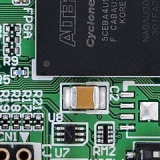

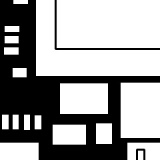

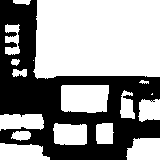

In [175]:
i = 3
display(load_img(test_input_img_paths[i]))

img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)

mask = np.argmax(test_preds[i], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
display(img)

1/1 [==============================] - 0s 22ms/step
12


(-0.5, 639.5, 479.5, -0.5)

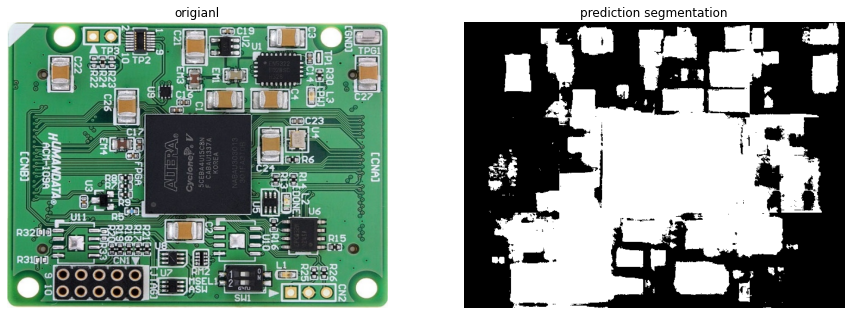

In [207]:
import cv2
import matplotlib.pyplot as plt
test_image_path = os.path.join(os.getcwd(),"images/ACM-109_Top90.jpg")
img = cv2.imread(test_image_path)
height, width = img.shape[:2]
new_h = (height//160)*160
new_w = (width//160)*160

img = cv2.resize(img,(new_w,new_h),interpolation = cv2.INTER_AREA)
im = np.asarray(img)
windows = []
for i in range(0,new_h,160):
    for j in range(0,new_w,160):
        windows.append(im[i:i+160,j:j+160])
windows = np.asarray(windows)
preds = pcb_unet_model.predict(windows)
k=0
print(len(preds))
res = np.zeros((new_h,new_w,1))

for i in range(0,new_h//160):
    for j in range(0,new_w//160):
        mask = np.argmax(preds[k], axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        res[i*160:i*160+160,j*160:j*160+160] = mask
        k+=1
res = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(res))
       
        
fig = plt.figure(figsize=(15, 10))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title("origianl")
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(res,cmap='gray')
plt.title("prediction segmentation")
plt.axis('off')